# 20. Green bands and bottom water oxygen
This notebook plots bottom water oxygen data from North Atlantic Site U1385 reconstructed with benthic carbon isotope measurements against green band data from U1313 and U1474. It generates Figure 4 from the main text.

## Setup
### Import modules

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

### Set paths

In [44]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'

## Import

### LR04

In [45]:
lr04=pd.read_csv(misc_path+'LR04stack.txt',sep='\t',index_col='Time (ka)')

### Benthic foraminiferal isotopes

In [47]:
am=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
am['Top Interval Depth CCSF (m)']=am['Depth CCSF (m)'].shift(1)
am['Top Interval Age (kyr)']=am['Age (ka BP)'].shift(1)
fam=interpolate.interp1d(am['Depth CCSF (m)'],am['Age (ka BP)'],bounds_error=False)

In [70]:
swchem=pd.read_csv(table_path+'Supplementary Table 1 - Benthic Foram Chemistry.csv')
swchem['Depositional Age (kyr)']=fam(swchem['Top depth CCSF (m)'])
aswchem=swchem.set_index('Depositional Age (kyr)',drop=False)

### Glacials

In [72]:
glacials=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[524, 563],[621, 676],
          [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
          [1114, 1141],[1190,1215],[1240,1265],[1285,1300]]
terminations=[[14,20],[130,140],[243,253],[337,347],[424,432],[529,535],[622,632]]

### Oxygen

In [73]:
o2_Thomas=pd.read_csv(misc_path+'339-U1385_stable_isotopes.tab',sep='\t',header=21,
                      index_col='Age [ka BP] (Age model, LR04 Lisiecki & Ra...)')
o2_Hoogaker=pd.read_csv(misc_path+'Hoogakker_2015b.tab',sep='\t',header=21,index_col='Age [ka BP]')
o2_Hoogaker.loc[o2_Hoogaker['O2 [µmol/kg]'].isnull(),'O2 [µmol/kg]']=235
o2_Hoogaker.loc[o2_Hoogaker['O2 [µmol/kg]']>235,'O2 [µmol/kg]']=235

In [74]:
o2_full=pd.concat([o2_Hoogaker['O2 [µmol/kg]'].dropna(),
                   o2_Thomas['O2 [µmol/kg] (Truncated, Calculated accordi...)']]).to_frame(name='O2')
o2_full['TF']=o2_full['O2']<230

### Green Bands

In [75]:
green_layers_U1474=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
green_layers_1313=pd.read_csv(table_path+'Supplementary Table 6B - U1313 green bands.csv')

In [76]:
submission_path='/Users/danielbabin/GitHub/Natal_Valley_Green_Layers/Manuscript/Initial Submission/'

In [77]:
green_true_U1474=green_layers_U1474.copy()

green_layers_1313['Class']=green_layers_1313['Label']-1
green_true_1313=green_layers_1313[green_layers_1313['Class']>0].copy()

In [78]:
amU1474=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
amU1474['Top Interval Depth CCSF (m)']=amU1474['Depth CCSF (m)'].shift(1)
amU1474['Top Interval Age (kyr)']=amU1474['Age (ka BP)'].shift(1)
famU1474=interpolate.interp1d(amU1474['Depth CCSF (m)'],amU1474['Age (ka BP)'],bounds_error=False)

In [79]:
am1313=pd.read_csv(misc_path+'1313_age_model_L*.csv')
fam1313=interpolate.interp1d(am1313['Depth (mcd)'],am1313['Age (ka)'],bounds_error=False)

In [100]:
am1313['Sedimentation Rate (cm/ka)']=((am1313['Depth (mcd)'].shift(1)-am1313['Depth (mcd)'])/
                                      (am1313['Age (ka)'].shift(1)-am1313['Age (ka)']))*100

In [81]:
green_true_U1474['Top Age (kyr)']=famU1474(green_true_U1474['Top Depth CCSF (m)'])
green_true_U1474['Bottom Age (kyr)']=famU1474(green_true_U1474['Bottom Depth CCSF (m)'])
agtU1474=green_true_U1474[~green_true_U1474['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [82]:
green_true_1313['Top Age (kyr)']=fam1313(green_true_1313['Top Depth CCSF (m)'])
green_true_1313['Bottom Age (kyr)']=fam1313(green_true_1313['Bottom Depth CCSF (m)'])
agt1313=green_true_1313[~green_true_1313['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

#### Create green band abundance record

In [83]:
step=1
bin_edges=np.arange(0,1200+step,step,dtype=int)

In [84]:
col_list=['U1474','U1474_C2+', 'U1474_C3', 
          '1313', '1313_C2+', '1313_C3']

In [85]:
thickness_records=pd.DataFrame(0,index=bin_edges,columns=col_list)
number_records=pd.DataFrame(0,index=bin_edges,columns=col_list)
for i,site in enumerate([agtU1474.loc[0:1200].copy(),agt1313.loc[0:1200].copy()]):
# for i,site in enumerate([agtU1474,agt1313,agt659,agt1143,agt758,agtU1489]):
    sitename=site['Site'].iloc[0]
    nearest=np.round(site.index/step)*step
    site['Nearest']=nearest
    
    thicknesses_total=site.groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c2_plus=site[site['Class']>1].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thicknesses_c3=site[site['Class']==3].groupby('Nearest').sum(numeric_only=True)['Thickness (cm)']
    thickness_records.loc[thicknesses_total.index,str(sitename)]=thicknesses_total.values
    thickness_records.loc[thicknesses_c2_plus.index,str(sitename)+'_C2+']=thicknesses_c2_plus.values
    thickness_records.loc[thicknesses_c3.index,str(sitename)+'_C3']=thicknesses_c3.values

    number_total=site.groupby('Nearest').count().iloc[:,0]
    number_c2_plus=site[site['Class']>1].groupby('Nearest').count().iloc[:,0]
    number_c3=site[site['Class']==3].groupby('Nearest').count().iloc[:,0]
    number_records.loc[number_total.index,str(sitename)]=number_total.values
    number_records.loc[number_c2_plus.index,str(sitename)+'_C2+']=number_c2_plus.values
    number_records.loc[number_c3.index,str(sitename)+'_C3']=number_c3.values

## Make Figure

In [86]:
violin_colors=sns.color_palette('magma',10).as_hex()
violin_colors

['#120d31',
 '#331067',
 '#59157e',
 '#7e2482',
 '#a3307e',
 '#c83e73',
 '#e95462',
 '#fa7d5e',
 '#fea973',
 '#fed395']

In [87]:
green_colors=sns.color_palette('Greens',3)
green_colors

[(0.7792233756247597, 0.9132333717800846, 0.7518031526336024),
 (0.45176470588235296, 0.7670895809304115, 0.4612072279892349),
 (0.1340253748558247, 0.5423298731257208, 0.26828143021914647)]

## Thickness

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


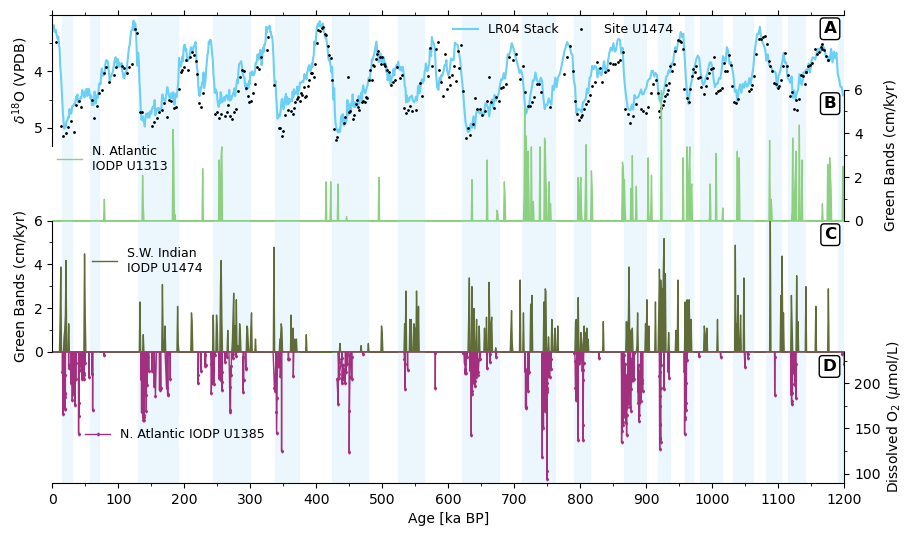

In [88]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1,label='LR04 Stack')
aswchem['benthic d18O'].loc[0:xmax].plot(ax=ax,color='k',marker='o',ms=1,ls='',label='Site U1474')
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)
legend=ax.legend(edgecolor='None', fontsize=9,ncol=2,loc=(0.5,.8),columnspacing=.8)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'
x=thickness_records[site].loc[0:xmax].index
ally=thickness_records[site].loc[0:xmax].values
c2plusy=thickness_records[site+'_C2+'].loc[0:xmax].values
c3y=thickness_records[site+'_C3'].loc[0:xmax].values

# ax.fill_between(x=x,y1=c2plusy,y2=ally,color=green_colors[0])
# ax.fill_between(x=x,y1=c3y,y2=c2plusy,color=green_colors[1])
# ax.fill_between(x=x,y1=0,y2=c3y,color=green_colors[2])
ax.fill_between(x=x,y1=0,y2=ally,color=color,lw=1)
ax.set_ylim(0,6)
ax.set_ylabel('Green Bands (cm/kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'
x=thickness_records[site].loc[0:xmax].index
ally=thickness_records[site].loc[0:xmax].values
c2plusy=thickness_records[site+'_C2+'].loc[0:xmax].values
c3y=thickness_records[site+'_C3'].loc[0:xmax].values

# ax.fill_between(x=x,y1=c2plusy,y2=ally,color=green_colors[0])
# ax.fill_between(x=x,y1=c3y,y2=c2plusy,color=green_colors[1])
# ax.fill_between(x=x,y1=0,y2=c3y,color=green_colors[2])
ax.fill_between(x=x,y1=0,y2=ally,color=color,lw=1)
ax.set_ylim(0,6)
ax.set_ylabel('Green Bands (cm/kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)

## Test bias for sedimentation rate

In [121]:
# Ensure both dataframes are sorted by depth
U1474_tie_points = amU1474.rename(columns={'Depth CCSF (m)':'Bottom Depth CCSF (m)'}).sort_values('Bottom Depth CCSF (m)').copy()
U1474_green_layers = green_layers_U1474.sort_values('Bottom Depth CCSF (m)').copy()

# Ensure both dataframes are sorted by depth
U1313_tie_points = am1313.rename(columns={'Depth (mcd)':'Bottom Depth CCSF (m)'}).sort_values('Bottom Depth CCSF (m)').copy()
U1313_green_layers = green_layers_1313.sort_values('Bottom Depth CCSF (m)').copy()

# Merge using merge_asof
U1474_result = pd.merge_asof(U1474_green_layers,
                             U1474_tie_points[['Bottom Depth CCSF (m)','Sedimentation Rate (cm/ka)']],
                             on='Bottom Depth CCSF (m)')
U1313_result = pd.merge_asof(U1313_green_layers,
                             U1313_tie_points[['Bottom Depth CCSF (m)','Sedimentation Rate (cm/ka)']],
                             on='Bottom Depth CCSF (m)')
U1313_result=U1313_result[U1313_result['Bottom Depth CCSF (m)']<57].copy()

(0.0, 5.0)

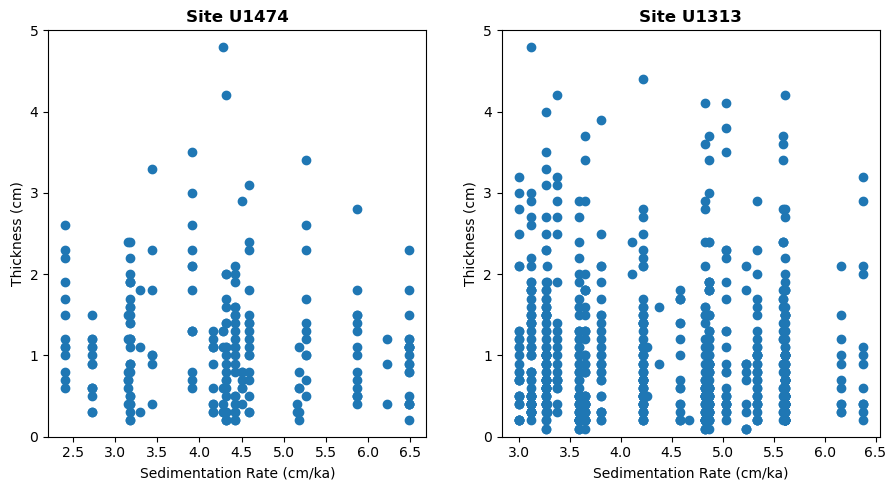

In [122]:
fig,axes=plt.subplots(ncols=2,figsize=(9,5))

ax=axes[0]
ax.scatter(U1474_result['Sedimentation Rate (cm/ka)'],U1474_result['Thickness (cm)'])
ax.set_xlabel('Sedimentation Rate (cm/ka)')
ax.set_ylabel('Thickness (cm)')
ax.set_title('Site U1474',fontweight='bold')
ax.set_ylim(0,5)

ax=axes[1]
ax.scatter(U1313_result['Sedimentation Rate (cm/ka)'],U1313_result['Thickness (cm)'])
ax.set_xlabel('Sedimentation Rate (cm/ka)')
ax.set_ylabel('Thickness (cm)')
ax.set_title('Site U1313',fontweight='bold')
plt.tight_layout()
ax.set_ylim(0,5)

## Number
### 1ky

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


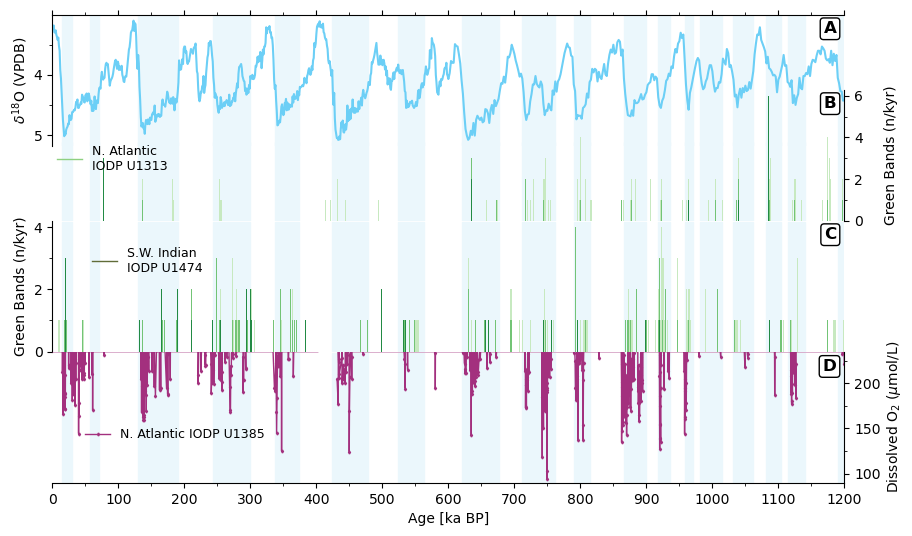

In [20]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1)
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'

# ax.hist(agt1313.index,bins=np.linspace(0,1200,1201))
classes=[agt1313[agt1313['Class']==3].index,agt1313[agt1313['Class']==2].index,agt1313[agt1313['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,1201),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'

# ax.hist(agtU1474.index,bins=np.linspace(0,1200,121))
classes=[agtU1474[agtU1474['Class']==3].index,agtU1474[agtU1474['Class']==2].index,agtU1474[agtU1474['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,1201),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)

### 2 ky

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


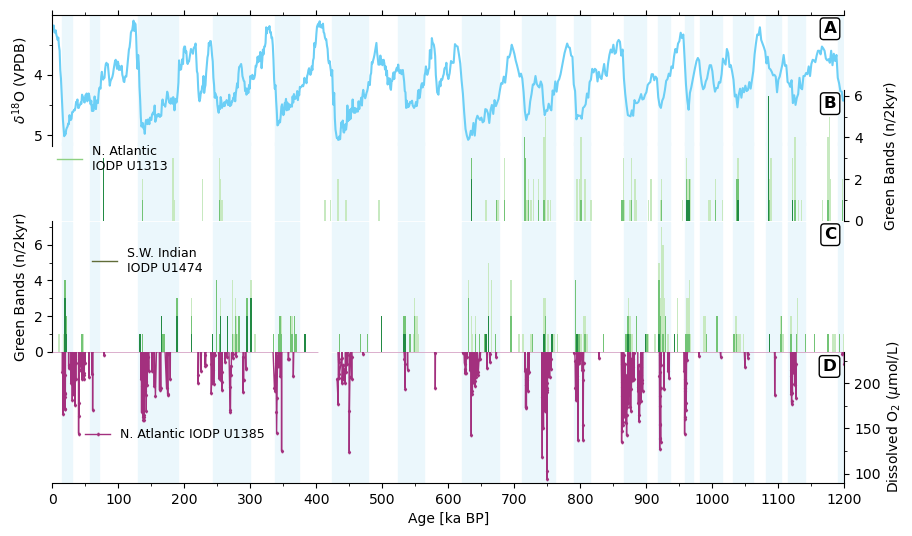

In [21]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1)
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'

# ax.hist(agt1313.index,bins=np.linspace(0,1200,1201))
classes=[agt1313[agt1313['Class']==3].index,agt1313[agt1313['Class']==2].index,agt1313[agt1313['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,601),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/2kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'

# ax.hist(agtU1474.index,bins=np.linspace(0,1200,121))
classes=[agtU1474[agtU1474['Class']==3].index,agtU1474[agtU1474['Class']==2].index,agtU1474[agtU1474['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,601),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/2kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)

### 5 ka

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


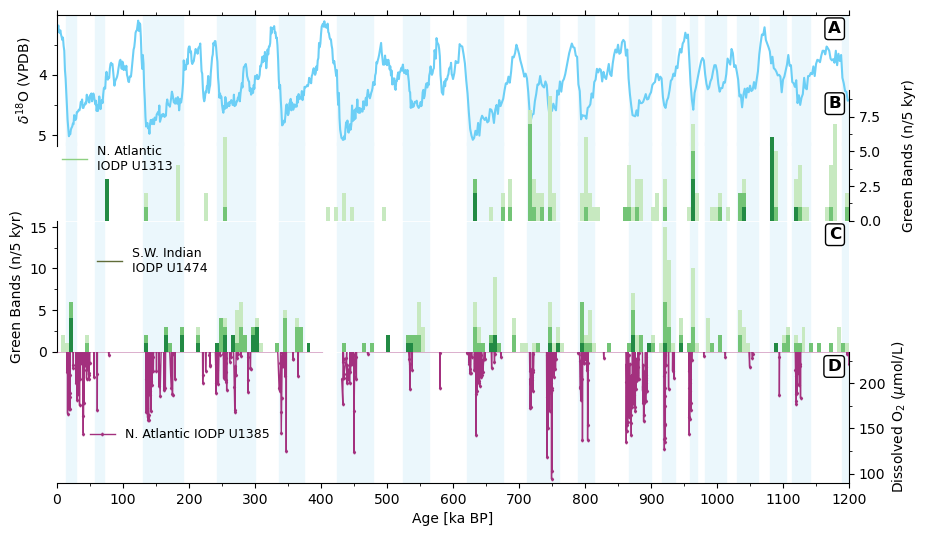

In [22]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1)
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'

# ax.hist(agt1313.index,bins=np.linspace(0,1200,1201))
classes=[agt1313[agt1313['Class']==3].index,agt1313[agt1313['Class']==2].index,agt1313[agt1313['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,201),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/5 kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'

# ax.hist(agtU1474.index,bins=np.linspace(0,1200,121))
classes=[agtU1474[agtU1474['Class']==3].index,agtU1474[agtU1474['Class']==2].index,agtU1474[agtU1474['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,201),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/5 kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


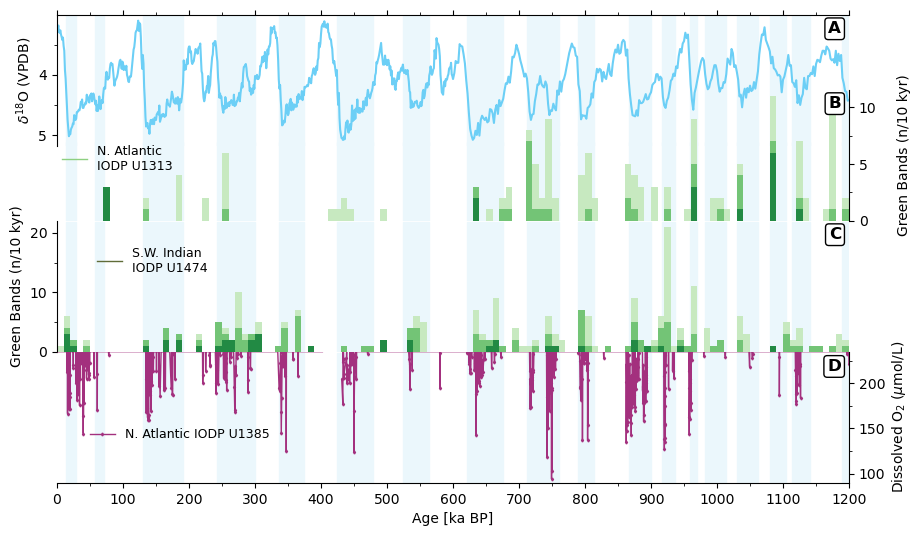

In [23]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1)
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'

# ax.hist(agt1313.index,bins=np.linspace(0,1200,1201))
classes=[agt1313[agt1313['Class']==3].index,agt1313[agt1313['Class']==2].index,agt1313[agt1313['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,121),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/10 kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'

# ax.hist(agtU1474.index,bins=np.linspace(0,1200,121))
classes=[agtU1474[agtU1474['Class']==3].index,agtU1474[agtU1474['Class']==2].index,agtU1474[agtU1474['Class']==1].index]
ax.hist(classes,bins=np.linspace(0,1200,121),stacked=True,color=green_colors[::-1])
ax.set_ylabel('Green Bands (n/10 kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)

## Presence-Absence

In [24]:
presence_records=number_records.copy()
presence_records[presence_records>0]=1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


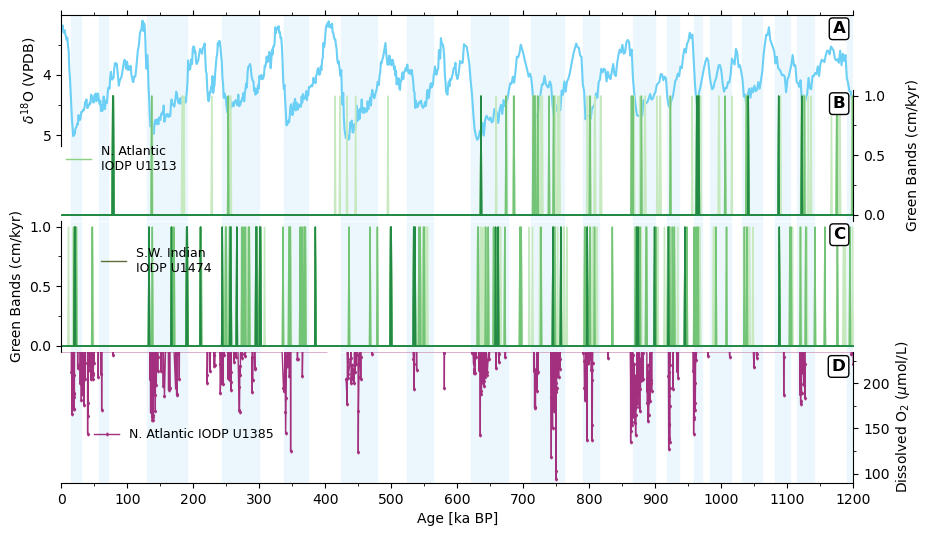

In [25]:
fig=plt.figure(figsize=(9,5.2),facecolor='w')
gs = gridspec.GridSpec(11, 1, figure=fig,hspace=-.6,top=.98,bottom=.08,right=.93,left=.05)
gsA = gs[:2].subgridspec(1, 1)
gsB = gs[2:11].subgridspec(3, 1,hspace=0)

ax0 = fig.add_subplot(gsA[0])
ax1 = fig.add_subplot(gsB[0])
ax2 = fig.add_subplot(gsB[1])
ax3 = fig.add_subplot(gsB[2])
axes=[ax0,ax1,ax2,ax3]

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=True,top=True,right=False,left=True)
sns.despine(ax=axes[2],bottom=True,top=True,right=True)
sns.despine(ax=axes[3],bottom=False,top=True,right=False,left=True)

sec0=axes[0].twinx()
sec0.axis('off')
sns.despine(ax=sec0,top=True,bottom=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in axes[1:-1]:
    ax.xaxis.set_visible(False)
for ax in [axes[1],axes[3]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    
xmax=1200    
    
######################################################################################################################## LR04
ax=axes[0]
# aswchem['benthic d18O'].loc[0:1180].dropna().plot(ax=ax,marker='o',ms=1,color='blue',zorder=1)
lr04['Benthic d18O (per mil)'].loc[0:xmax].plot(ax=ax,color='#6CCFF6',zorder=-1)
ax.invert_yaxis()
ax.set_ylabel('$\delta^{18}$O (VPDB)',labelpad=3)
ax.set_yticks([4,5])
ylim = ax.get_ylim()
# ax.set_ylim(ylim[0]-.2,ylim[1]-.2)

ax.axvspan(xmin=0,xmax=300,ymin=1,ymax=1.2)

######################################################################################################################## 1313
color='#8ED081'
ax=axes[1]
site='1313'
x=presence_records[site].loc[0:xmax].index
ally=presence_records[site].loc[0:xmax].values
c2plusy=presence_records[site+'_C2+'].loc[0:xmax].values
c3y=presence_records[site+'_C3'].loc[0:xmax].values

ax.fill_between(x=x,y1=c2plusy,y2=ally,color=green_colors[0])
ax.fill_between(x=x,y1=c3y,y2=c2plusy,color=green_colors[1])
ax.fill_between(x=x,y1=0,y2=c3y,color=green_colors[2])
# ax.fill_between(x=x,y1=0,y2=ally,color=color)
# ax.set_ylim(0,4)
ax.set_ylabel('Green Bands (cm/kyr)',labelpad=15)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['N. Atlantic\nIODP U1313'],loc=(0,.33),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## U1474
color='#606C38'
ax=axes[2]
site='U1474'
x=presence_records[site].loc[0:xmax].index
ally=presence_records[site].loc[0:xmax].values
c2plusy=presence_records[site+'_C2+'].loc[0:xmax].values
c3y=presence_records[site+'_C3'].loc[0:xmax].values

ax.fill_between(x=x,y1=c2plusy,y2=ally,color=green_colors[0])
ax.fill_between(x=x,y1=c3y,y2=c2plusy,color=green_colors[1])
ax.fill_between(x=x,y1=0,y2=c3y,color=green_colors[2])
# ax.fill_between(x=x,y1=0,y2=ally,color=color)
# ax.set_ylim(0,4)
ax.set_ylabel('Green Bands (cm/kyr)')
ax.legend()

custom_lines = [Line2D([0], [0], color=color, lw=1)]
legend=ax.legend(custom_lines, ['S.W. Indian\nIODP U1474'],loc=(.044,.55),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))


######################################################################################################################## Oxygen
ax=axes[3]

color_n=4
o2_Thomas.loc[420,'O2 [µmol/kg] (Truncated, Calculated accordi...)']=np.nan
o2_Thomas=o2_Thomas.sort_index()
col='O2 [µmol/kg] (Truncated, Calculated accordi...)'
df=o2_Thomas.loc[o2_Thomas[col]<235,col].loc[0:xmax]
df.plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Thomas.loc[0:xmax,col].plot(ax=ax,lw=1,color=violin_colors[color_n])

col='O2 [µmol/kg]'
df=o2_Hoogaker.loc[o2_Hoogaker[col]<235,col].loc[0:xmax]
df.dropna().plot(ax=ax,lw=1,color=violin_colors[color_n],marker='d',ms=1.5,ls='')
o2_Hoogaker[col].dropna().plot(ax=ax,lw=1,color=violin_colors[color_n])

ax.set_ylim(90,235)
ax.set_ylabel('Dissolved O$_2$ ($\mu$mol/L)',labelpad=3)

custom_lines = [Line2D([0], [0], color=violin_colors[color_n], lw=1, marker='d', ls='-', ms=1.5)]
legend=ax.legend(custom_lines, ['N. Atlantic IODP U1385'],loc=(.035,.28),
                 edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))

########################################################################################################################
ymaxes=[1,.6,.99,.99,.57]       
for i,ax in enumerate(axes):
    for g in glacials:
        start=g[0]
        end=g[1]
        ax.axvspan(xmin=start,xmax=end,ymax=ymaxes[i],zorder=-10,color='#ebf7fc')
        
letters=['A','B','C']
for n,ax in enumerate(axes[:-1]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))
axes[3].annotate('D',xy=(.99,.83),xycoords='axes fraction',ha='right',va='bottom',fontsize=12,fontweight='bold',
            bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

    
for ax in axes:
    ax.set_xlim(0,1200)

axes[0].xaxis.tick_top()
for ax in [axes[0],axes[-1]]:
    ax.xaxis.set_major_locator(MultipleLocator(100))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
axes[0].set_xticklabels([])
axes[0].set_xlabel('')

for ax in axes:
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))


axes[-1].set_xlim(0,xmax)
fig.savefig(figure_path+'Figure 4 - Green banding records and bottom water oxygen',dpi=300)